# Extracting attributes from Fashion wear image data set

In [1]:
#Importing the required libraries
import pandas as pd
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# !pip install scikit-image
from skimage import transform
# Helper libraries
import numpy as np
from IPython.display import display, HTML
# import matplotlib.pyplot as pl
import scipy
import glob,os
import PIL.Image as Image
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image as KearsImage
import glob
import os
import random

In [2]:
MODEL_PATH_PRINT = 'demo_print_model'
MODEL_PATH_CLOTH = 'demo_cloth_model'
checkpoint_path = '/Users/i516344/Downloads/Inception3_V1weights-24-0.76\ .hdf5'
checkpoint_path = '/Users/i516344/PycharmProjects/pythonProject/fashion/VGG16-4Dense-300by300-1000sample-weights-43-0.70.hdf5'
display(HTML("<style>.container { width:75% !important; }</style>"))
actual_print_style = ['classic', 'abstract', 'floral', 'stripe', 'stripe']
actual_cloth_style = ['dress', 'skirt', 'top', 'top', 'top']

In [4]:
class Update:
    def __init__(self, model, dataset, column, classes):
        self.model = model
        shape = model.inputs[0].get_shape()
        self.image_height = shape[1]
        self.image_width = shape[2]
        self.channels = shape[3]
#         print("Input_shape", self.image_height, self.image_width)
    def update_data(self, model, dataset, column, classes):
        missing_values = dataset.loc[dataset[column].isna()]
        images = missing_values['images']
        probabilities = []
        for image in images:
            img = KearsImage.load_img(image, target_size = [self.image_height, self.image_width])
            input_arr = keras.preprocessing.image.img_to_array(img)
            input_arr = np.array([input_arr]).astype('float32')/255  # Convert single image to a batch.
            predictions = model.predict(input_arr)
            predictions =  np.around(predictions[0], 4)
            probability = np.max(predictions)
            category = classes[np.argmax(predictions)]
            dataset.loc[dataset['images'] == image, column] = category
            probabilities.append(probability)
        dataset['probability_' + column] = probabilities

def predictAttributes(dataset):
    print_model = keras.models.load_model(MODEL_PATH_PRINT)
    cloth_model = keras.models.load_model(MODEL_PATH_CLOTH)
    print_classes = {0: 'abstract', 1: 'classic', 2: 'floral', 3: 'stripe'}
    cloth_classes = {0: 'dress', 1:'jeans', 2: 'skirt', 3: 'top'}
    #print(dataset.head(5))
    update = Update(print_model, dataset, 'print_style', print_classes)
    update.update_data(print_model, dataset, 'print_style', print_classes)
    update = Update(cloth_model, dataset, 'cloth_style', cloth_classes)
    update.update_data(cloth_model, dataset, 'cloth_style', cloth_classes)

In [5]:
#Loading the data from the HDF store
store = pd.HDFStore('data_store.h5')

In [6]:
def load_customer_data(hdfstore):
    #Loading the customer data
    customer_data = hdfstore['customer_data']
    customer_data = customer_data.assign(product_image=" ")
    demo_images = os.path.join('demo_images', '*jpg')
    demo_image_names = glob.glob(demo_images)
    
    #Randomly assign the images to the customer data
    for index, row in customer_data.iterrows():
        customer_data.at[index,'product_image'] = random.choice(demo_image_names)
    
    return customer_data

# Data understanding

In [27]:
#Load the customer data
customer_df = load_customer_data(store)

In [28]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 5173717 to 396346
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   marketplace     100000 non-null  object
 1   transaction_id  100000 non-null  int64 
 2   customer_id     100000 non-null  object
 3   product_id      100000 non-null  object
 4   product_title   100000 non-null  object
 5   age             100000 non-null  int64 
 6   gender          100000 non-null  int64 
 7   product_image   100000 non-null  object
dtypes: int64(3), object(5)
memory usage: 9.4+ MB


In [29]:
customer_df.head()

,marketplace,transaction_id,customer_id,product_id,product_title,age,gender,product_image
5173717,US,8864773,R3KOFMJ8WVWEQR,B00299EQTQ,Music Legs Fishnet seamless pantyhose,18,0,demo_images\demo_img4.jpg
1576078,US,25215324,R15TMP3YX8N44H,B00IJJF8HY,Bruce Lee hi-YAH! Print Men's Fitted Shirt,21,0,demo_images\demo_img5.jpg
307445,US,46763639,R1IXLR8H59B4LC,B00RH0PLDC,U.S. Polo Assn. Little Girls' Ruffled Striped ...,21,0,demo_images\demo_img3.jpg
2692549,US,45087076,R3OS38SF0NY9MN,B00CN5HG48,Allegra K Women's Button Detail V Neck Batwing...,57,0,demo_images\demo_img1.jpg
4803418,US,1611995,R28S3DBEYXZSYN,B003T9VL1G,Lee Men's Regular Fit Straight Leg Jean,27,0,demo_images\demo_img3.jpg


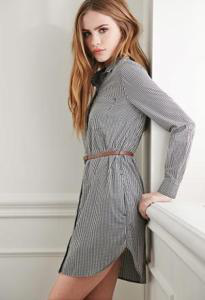

Actual Print Style:  classic
Actual Cloth Style:  dress
-------------------------------------------------------


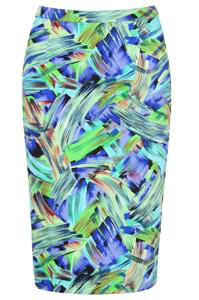

Actual Print Style:  abstract
Actual Cloth Style:  skirt
-------------------------------------------------------


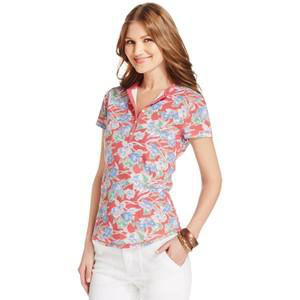

Actual Print Style:  floral
Actual Cloth Style:  top
-------------------------------------------------------


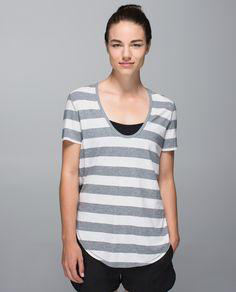

Actual Print Style:  stripe
Actual Cloth Style:  top
-------------------------------------------------------


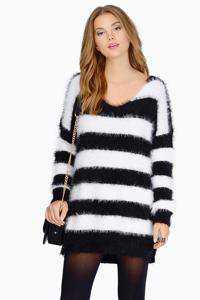

Actual Print Style:  stripe
Actual Cloth Style:  top
-------------------------------------------------------


In [10]:
#Load the images of the clothes bought my these customers
demo_images = os.path.join('demo_images', '*jpg')
demo_image_names = glob.glob(demo_images)
i = 0

for image_name in demo_image_names:
    image  = Image.open(image_name)
    display(image)
    print("Actual Print Style: ",actual_print_style[i])
    print("Actual Cloth Style: ",actual_cloth_style[i])
    print("-------------------------------------------------------")
    i = i+1

# Extracting attributes from the images

In [11]:
#Constructing the image data set
img_dataset = pd.DataFrame()
img_dataset['images'] = demo_image_names
img_dataset = img_dataset.assign(print_style=None,cloth_style=None)

In [12]:
img_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   images       5 non-null      object
 1   print_style  0 non-null      object
 2   cloth_style  0 non-null      object
dtypes: object(3)
memory usage: 248.0+ bytes


In [13]:
img_dataset.head()

,images,print_style,cloth_style
0,demo_images\demo_img1.jpg,None,None
1,demo_images\demo_img2.jpg,None,None
2,demo_images\demo_img3.jpg,None,None
3,demo_images\demo_img4.jpg,None,None
4,demo_images\demo_img5.jpg,None,None


In [14]:
#Using the previously trained model to extract attributes from the images
predictAttributes(img_dataset)

In [15]:
img_dataset = img_dataset.rename(columns={"images": "product_image"})


In [30]:
img_dataset

,product_image,print_style,cloth_style,probability_print_style,probability_cloth_style
0,demo_images\demo_img1.jpg,classic,dress,0.9208,0.4982
1,demo_images\demo_img2.jpg,abstract,skirt,0.9790,0.4645
2,demo_images\demo_img3.jpg,floral,top,0.9342,0.6377
3,demo_images\demo_img4.jpg,stripe,top,0.9991,0.8339
4,demo_images\demo_img5.jpg,stripe,top,0.9998,0.5854


In [31]:
#Merge the predictions with the customer data
customer_df = pd.merge(customer_df,
                         img_dataset,
                         how="inner",
                         on='product_image'
                        )

In [32]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   marketplace              100000 non-null  object 
 1   transaction_id           100000 non-null  int64  
 2   customer_id              100000 non-null  object 
 3   product_id               100000 non-null  object 
 4   product_title            100000 non-null  object 
 5   age                      100000 non-null  int64  
 6   gender                   100000 non-null  int64  
 7   product_image            100000 non-null  object 
 8   print_style              100000 non-null  object 
 9   cloth_style              100000 non-null  object 
 10  probability_print_style  100000 non-null  float64
 11  probability_cloth_style  100000 non-null  float64
dtypes: float64(2), int64(3), object(7)
memory usage: 9.9+ MB


In [33]:
customer_df.head()

,marketplace,transaction_id,customer_id,product_id,product_title,age,gender,product_image,print_style,cloth_style,probability_print_style,probability_cloth_style
0,US,8864773,R3KOFMJ8WVWEQR,B00299EQTQ,Music Legs Fishnet seamless pantyhose,18,0,demo_images\demo_img4.jpg,stripe,top,0.9991,0.8339
1,US,15750671,R3A5ARENA0C8YN,B001LIVQLM,Jockey Women’s Plus Size Robe,24,0,demo_images\demo_img4.jpg,stripe,top,0.9991,0.8339
2,US,24937044,R1P27PZAH14HKG,B005HI8OIU,Christmas Santa Claus Hawaiian Shirt,42,0,demo_images\demo_img4.jpg,stripe,top,0.9991,0.8339
3,US,22009648,R1L488LB4KP7CR,B000OQN9DK,Hanes Girls' Hipster Panty (9-Pack),19,0,demo_images\demo_img4.jpg,stripe,top,0.9991,0.8339
4,US,17025632,R2VPP5I6YG9LC7,B00DVGCG2K,Torrid Women's Plus Size Striped Peplum Sleeve...,56,0,demo_images\demo_img4.jpg,stripe,top,0.9991,0.8339


# Verifying the accuracy of the predictions

In [34]:
#Evaluating the accuracy of the prediction
img_dataset['actual_print_style'] = ['classic', 'abstract', 'floral', 'stripe', 'stripe']
img_dataset['actual_cloth_style'] = ['dress', 'skirt', 'top', 'top', 'top']
img_dataset

,product_image,print_style,cloth_style,probability_print_style,probability_cloth_style,actual_print_style,actual_cloth_style
0,demo_images\demo_img1.jpg,classic,dress,0.9208,0.4982,classic,dress
1,demo_images\demo_img2.jpg,abstract,skirt,0.9790,0.4645,abstract,skirt
2,demo_images\demo_img3.jpg,floral,top,0.9342,0.6377,floral,top
3,demo_images\demo_img4.jpg,stripe,top,0.9991,0.8339,stripe,top
4,demo_images\demo_img5.jpg,stripe,top,0.9998,0.5854,stripe,top


In [35]:
img_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_image            5 non-null      object 
 1   print_style              5 non-null      object 
 2   cloth_style              5 non-null      object 
 3   probability_print_style  5 non-null      float64
 4   probability_cloth_style  5 non-null      float64
 5   actual_print_style       5 non-null      object 
 6   actual_cloth_style       5 non-null      object 
dtypes: float64(2), object(5)
memory usage: 408.0+ bytes


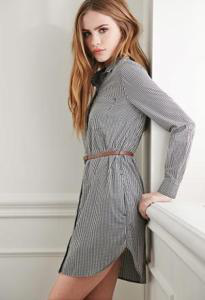

Actual Print Style:  classic
Predicted Print Style: classic(Probability=0.92) 
Actual Cloth Style:  dress
Predicted Print Style: dress(Probability=0.50) 
--------------------------------------------------------------------


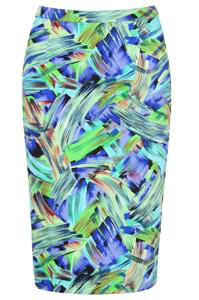

Actual Print Style:  abstract
Predicted Print Style: abstract(Probability=0.98) 
Actual Cloth Style:  skirt
Predicted Print Style: skirt(Probability=0.46) 
--------------------------------------------------------------------


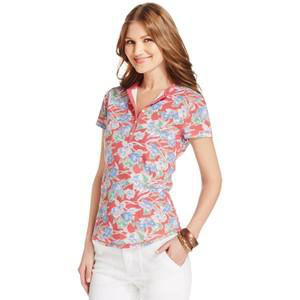

Actual Print Style:  floral
Predicted Print Style: floral(Probability=0.93) 
Actual Cloth Style:  top
Predicted Print Style: top(Probability=0.64) 
--------------------------------------------------------------------


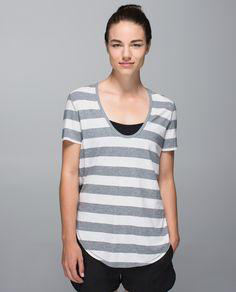

Actual Print Style:  stripe
Predicted Print Style: stripe(Probability=1.00) 
Actual Cloth Style:  top
Predicted Print Style: top(Probability=0.83) 
--------------------------------------------------------------------


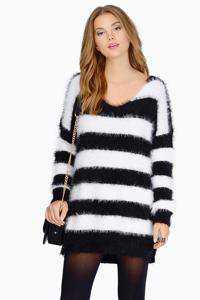

Actual Print Style:  stripe
Predicted Print Style: stripe(Probability=1.00) 
Actual Cloth Style:  top
Predicted Print Style: top(Probability=0.59) 
--------------------------------------------------------------------


In [37]:
i = 0
for index, row in img_dataset.iterrows():
    
    image  = Image.open(row['product_image'])
    actual_print_style = row['actual_print_style']
    actual_cloth_style = row['actual_cloth_style']
    pred_print_style = row['print_style']
    pred_cloth_style = row['cloth_style']
    prob_print_style = row['probability_print_style']
    prob_cloth_style = row['probability_cloth_style']
    
    display(image)
    
    print("Actual Print Style: ",actual_print_style)
    print("Predicted Print Style: %s(Probability=%.2f) " %(pred_print_style,prob_print_style))

    print("Actual Cloth Style: ",actual_cloth_style)
    print("Predicted Print Style: %s(Probability=%.2f) " %(pred_cloth_style,prob_cloth_style))
    print("--------------------------------------------------------------------")

    